# Setting up the notebook

In [8]:
%matplotlib inline
import os

import sys
win_home_module_path = r'/Users/s4686401/Documents/sensing_volume/simulation/MODULES' #insert path of QCL_methods.py file
sys.path.insert(1, win_home_module_path)

from QCL_methods import QCLFigure, arrayCenterCrop, propagate, back_propagate, mirror, mirror_phase, applyQuadraticPhase

import numpy as np
from numpy.fft import fftshift, ifftshift, fft2, ifft2, fftfreq

import matplotlib.pyplot as plt
import hdf5storage

# Setup parameters

In [26]:
N_pad = 2001 # determines how big is the simulation field of view 

QCL_offset_x = 0e-6 # x-offset of the QCl in [m]
QCL_offset_y = 90e-6 # y-offset of the QCl in [m]

lens_clear_aperture_radius = 25e-3/2 # clear lens aperature diameter of collimating lens
lens_clear_aperture_radius_L2 = 30e-3/2 # clear lens aperature diameter of focusing lens

d1 = 29.7e-3 # distance from QCL to the first lens [m]
f1 = 30e-3 # focal length of lens L1 in [m]

d2 = 1600e-3 # distance between lenses L1 and L2 [m]
f2 = 50e-3 # focal length of lens L2

d3 = 52.5e-3 # propagation distance from lens L2 to sample

# Load  QCL output profile

The grid pixel size is 1.0e-05 [m]
QCL output is oversampled 5.26 times


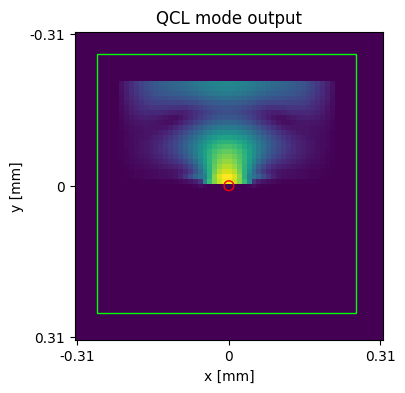

In [27]:
data = hdf5storage.loadmat("QCL_laser_output.mat")
E_QCL_raw = np.sqrt(data['I0_sample']) # convert I to E
E_QCL_raw = E_QCL_raw/E_QCL_raw.max() # normalise to 1

rangeX = 1e-3*(data['x0_03_row'].max()) #rangeX in [m]
N_steps_X = data['x0_03_row'].shape[1]
rangeY = 1e-3*(data['x0_03_column'].max()) #rangeY in [m]
N_steps_Y = data['x0_03_column'].shape[1]

samplingX, stepX = np.linspace(-rangeX, rangeX, N_steps_X, retstep = True, dtype='float32')
samplingY, stepY = np.linspace(-rangeY, rangeY, N_steps_Y, retstep = True, dtype='float32')

X, Y = np.meshgrid(samplingX, samplingY)
dimY, dimX = X.shape

pixelSize = stepX # it is a square pixel so stepX = stepY 

print(f'The grid pixel size is {pixelSize:0.1e} [m]')

frequency = 2.85e12 # operating laser frequency in [Hz]
c0 = 299792458 # speed of light in [m/s]
wavelength = c0/frequency # wavelength in [m]
nu_cutoff = 1/wavelength
pixelSize_Nyquist = (1/(2*nu_cutoff))

oversample = pixelSize_Nyquist/pixelSize
print(f'QCL output is oversampled {oversample:0.2f} times')

E_QCL_raw_fig = QCLFigure(1,1,5,4)
E_QCL_raw_fig.plot(np.abs(E_QCL_raw), pixelSize, title = 'QCL mode output', plot_center_circle = True,
                   plot_integration_area = True, colormap = 'viridis')

### Note: The QCL ouput cannot be easily centered. I have to do subpixel centering!! Also the ouput is oversampled in terms of what spatial frequencies can actually make it to the far-field.

# Upsample, pixel shift for center, downsample

Size of pixel in downsampled data 5.7273e-05 [m]
Size of pixel in upsampled data 1.5498e-07 [m]
Fine x-offset to apply now 0.0 [m]
Fine y-offset to apply now 3.2727272727273145e-05 [m]
Rolling x by 0 pixels, 0.000e+00
Rolling y by 211 pixels, 3.270e-05
y-offset remaining 5.727e-05 [m], 1 pixels
x-offset remaining 0.000e+00 [m], 0 pixels


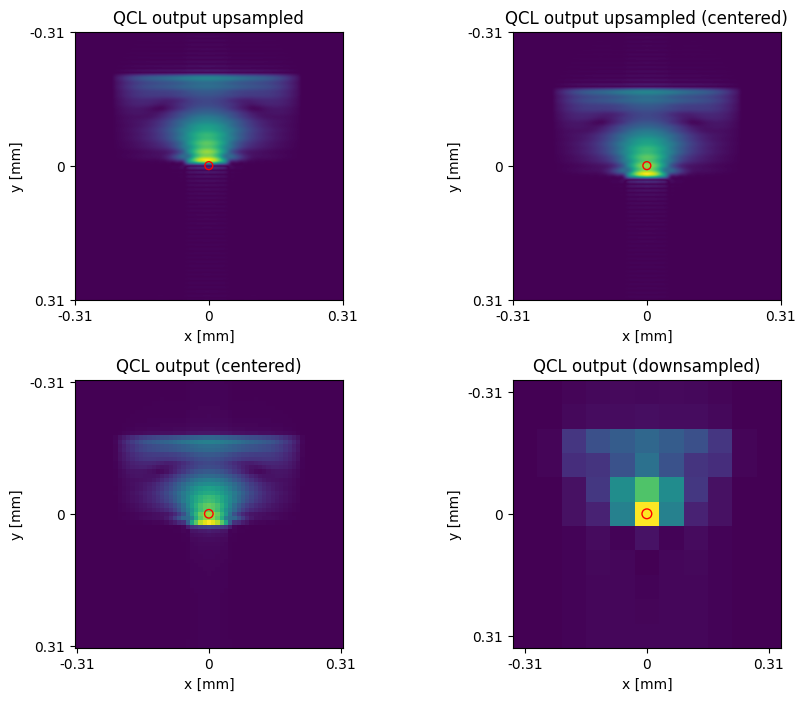

In [28]:
_pad = 2001

# upsampling the raw QCL data
QCL_ffted = fftshift(fft2(ifftshift(E_QCL_raw)))
QCL_ffted_pad = np.pad(QCL_ffted, ((_pad,_pad),(_pad,_pad)),'constant', constant_values = 0)
QCL_upsampled = fftshift(ifft2(ifftshift(QCL_ffted_pad)))
QCL_upsampled = QCL_upsampled/QCL_upsampled.max()

up_pixelSize = pixelSize * dimX/(_pad*2 + dimX)

down_pixelSize = pixelSize*(dimX/11)
print(f'Size of pixel in downsampled data {down_pixelSize:0.4e} [m]')

# Adding fine offset in x and y
print(f'Size of pixel in upsampled data {up_pixelSize:0.4e} [m]')
print(f'Fine x-offset to apply now {QCL_offset_x%down_pixelSize} [m]')
print(f'Fine y-offset to apply now {QCL_offset_y%down_pixelSize} [m]')

E_QCL_centering = QCLFigure(2,2,10,8,wspace = 0.3, hspace = 0.3)
E_QCL_centering.plot(np.abs(QCL_upsampled), up_pixelSize, pos = (0,0), title = 'QCL output upsampled', 
                     plot_center_circle = True, circle_radius = 60, zoom = 1, colormap = 'viridis')

# offsetting the upsampled data by half the size of the original pixel (newDim/oldDim/2)
roll_shift = int(np.floor((_pad*2 + dimX)/dimX/2))
QCL_upsampled_centered = np.roll(QCL_upsampled, roll_shift, axis = 1)

# applying the fine x/y QCL offset (the rest of the offset will be applied by pixel shift in downsampled data)
roll_fine_x = int((QCL_offset_x%down_pixelSize)//up_pixelSize)
roll_fine_y = int((QCL_offset_y%down_pixelSize)//up_pixelSize)

print(f'Rolling x by {roll_fine_x} pixels, {roll_fine_x*up_pixelSize:0.3e}')
print(f'Rolling y by {roll_fine_y} pixels, {roll_fine_y*up_pixelSize:0.3e}')

QCL_offset_y_remaining = QCL_offset_y - QCL_offset_y%down_pixelSize
print(f'y-offset remaining {QCL_offset_y_remaining:0.3e} [m], {int(QCL_offset_y_remaining//down_pixelSize)} pixels')
QCL_offset_x_remaining = QCL_offset_x - QCL_offset_x%down_pixelSize
print(f'x-offset remaining {QCL_offset_x_remaining:0.3e} [m], {int(QCL_offset_x_remaining//down_pixelSize)} pixels')

QCL_offset_x_remaining = int(QCL_offset_x_remaining//down_pixelSize)
QCL_offset_y_remaining = int(QCL_offset_y_remaining//down_pixelSize)

QCL_upsampled_centered = np.roll(QCL_upsampled_centered, roll_fine_y, axis = 0)
QCL_upsampled_centered = np.roll(QCL_upsampled_centered, roll_fine_x, axis = 1)

E_QCL_centering.plot(np.abs(QCL_upsampled_centered), up_pixelSize, pos = (0,1), title = 'QCL output upsampled (centered)',
                     plot_center_circle = True, circle_radius = 60, zoom = 1,colormap = 'viridis')


# downsample back to original but now centered
QCL_ffted = fftshift(fft2(ifftshift(QCL_upsampled_centered)))
QCL_ffted_trim = arrayCenterCrop(QCL_ffted, dimX)
QCL_centered = fftshift(ifft2(ifftshift(QCL_ffted_trim)))
QCL_centered = QCL_centered/QCL_centered.max()

E_QCL_centering.plot(np.abs(QCL_centered), pixelSize, pos = (1,0), title = 'QCL output (centered)',
                     plot_center_circle = True, circle_radius = 1, zoom = 1, colormap = 'viridis')

# downsample even more because spatial frequency cutoff will not allow most details to propagate to far-field
QCL_ffted = fftshift(fft2(ifftshift(QCL_centered)))
QCL_ffted_trim = arrayCenterCrop(QCL_ffted, 11) # 63/oversample gives 10.88, eleven should capture all details in far-field
QCL_downsampled = fftshift(ifft2(ifftshift(QCL_ffted_trim)))
QCL_downsampled = QCL_downsampled/QCL_downsampled.max()


E_QCL_centering.plot(np.abs(QCL_downsampled), down_pixelSize, pos = (1,1), title = 'QCL output (downsampled)',
                     plot_center_circle = True, circle_radius = 0.2, zoom = 1, colormap = 'viridis')

### <span style="color:red"> WARNING: The subpixel shift might be in the opposite direction as it is then compensated by a full pixel shift. Check the cell below to see if the QCL ouput moves in the correct direction.</span>

# Calculate propagator, grid and other useful stuff

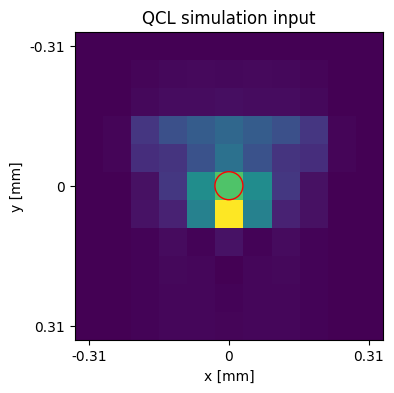

In [29]:
E_QCL_sim_input = np.pad(QCL_downsampled, 
                         ((N_pad + QCL_offset_y_remaining, N_pad - QCL_offset_y_remaining),
                          (N_pad + QCL_offset_x_remaining, N_pad - QCL_offset_x_remaining)),
                         'constant', constant_values = 0).astype(np.complex64)


fig1 = QCLFigure(1,1,5,4)
fig1.plot(np.abs(E_QCL_sim_input), down_pixelSize, pos = (0,0), title = 'QCL simulation input', 
          plot_center_circle = True, circle_radius = 0.5, zoom = 350, colormap = 'viridis')

_dimX, _dimY = E_QCL_sim_input.shape

rangeX = down_pixelSize*(_dimX-1)/2
rangeY = down_pixelSize*(_dimY-1)/2

N_steps_X = _dimX
N_steps_Y = _dimY

samplingX, stepX = np.linspace(-rangeX, rangeX, N_steps_X, retstep = True, dtype='float32')
samplingY, stepY = np.linspace(-rangeY, rangeY, N_steps_Y, retstep = True, dtype='float32')

X, Y = np.meshgrid(samplingX, samplingY)
dimY, dimX = X.shape
pixelSizeX = stepX
pixelSizeY = stepY

k_samplingX = 2*np.pi*fftshift(fftfreq(dimX, d = pixelSizeX))
k_samplingY = 2*np.pi*fftshift(fftfreq(dimY, d = pixelSizeY))

kx, ky = np.meshgrid(k_samplingX, k_samplingY)
k0 = 2*np.pi/wavelength
propagator = (np.lib.scimath.sqrt(k0**2-kx**2-ky**2)).astype(np.complex64)

R = np.sqrt(X**2 + Y**2)
R_squared = R**2
lens_aperture = (R < lens_clear_aperture_radius).astype(np.int8) # filter mask equal to the lens clear aperture
lens_aperture_L2 = (R < lens_clear_aperture_radius_L2).astype(np.int8) # filter mask equal to the lens clear aperture

# Propagation to lens L1

In [30]:
# propagate QCL output by d1
E_enter_L1_forward = propagate(E_QCL_sim_input, propagator, d1)

# apply lens clear aperture
E_enter_L1_forward_apertured = (E_enter_L1_forward*lens_aperture).astype(np.complex64)

# apply quadratic phase of the lens
E_exit_L1_forward = applyQuadraticPhase(E_enter_L1_forward_apertured, wavelength, f1, R_squared)

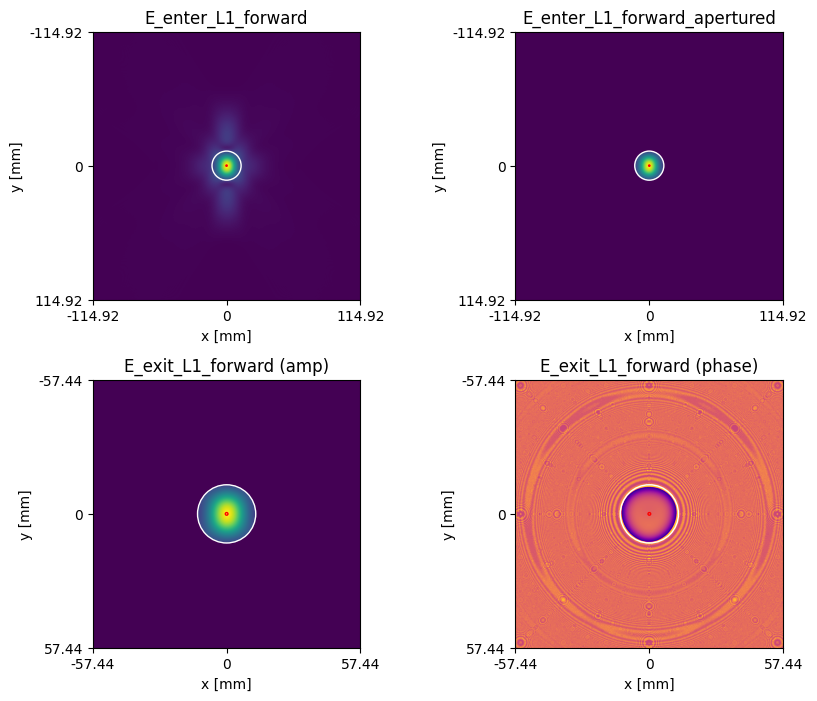

In [31]:
fig2 = QCLFigure(2,2,10,8, hspace = 0.3)
fig2.plot(np.abs(E_enter_L1_forward), pixelSizeX, pos = (0,0), title = 'E_enter_L1_forward', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 1,colormap = 'viridis')
fig2.plot(np.abs(E_enter_L1_forward_apertured), pixelSizeX, pos = (0,1), title = 'E_enter_L1_forward_apertured', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 1,colormap = 'viridis')
fig2.plot(np.abs(E_exit_L1_forward), pixelSizeX, pos = (1,0), title = 'E_exit_L1_forward (amp)', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig2.plot(np.angle(E_exit_L1_forward), pixelSizeX, pos = (1,1), title = 'E_exit_L1_forward (phase)', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'plasma')

# Propagation to lens L2 and sample

In [32]:
# propagate  from lens L1 to L2 (distance d2)
E_enter_L2_forward = propagate(E_exit_L1_forward, propagator, d2)

# apply lens clear aperture
E_enter_L2_forward_apertured = (E_enter_L2_forward*lens_aperture_L2).astype(np.complex64)


# apply quadratic phase of the lens     
E_exit_L2_forward = applyQuadraticPhase(E_enter_L2_forward_apertured, wavelength, f2, R_squared)

# propagate  from lens L2 to sample (distance d3)
E_sample_forward = propagate(E_exit_L2_forward, propagator, d3)

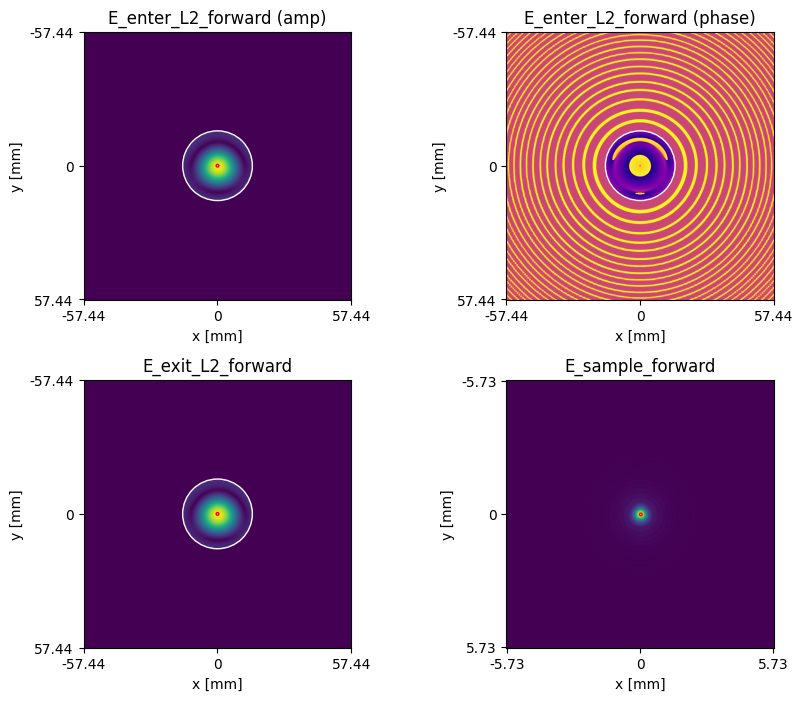

In [33]:
fig3 = QCLFigure(2,2,10,8, hspace = 0.3)
fig3.plot(np.abs(E_enter_L2_forward_apertured), pixelSizeX, pos = (0,0), title = 'E_enter_L2_forward (amp)', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius_L2, zoom = 2, colormap = 'viridis')
fig3.plot(np.angle(E_enter_L2_forward_apertured), pixelSizeX, pos = (0,1), title = 'E_enter_L2_forward (phase)', 
          plot_center_circle = True, circle_radius = 1,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius_L2, zoom = 2, colormap = 'plasma')
fig3.plot(np.abs(E_exit_L2_forward), pixelSizeX, pos = (1,0), title = 'E_exit_L2_forward', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius_L2, zoom = 2, colormap = 'viridis')
fig3.plot(np.abs(E_sample_forward), pixelSizeX, pos = (1,1), title = 'E_sample_forward', 
          plot_center_circle = True, circle_radius = 1,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius_L2, zoom = 20, colormap = 'viridis')

# Mirror field on the sample and back-propagate from the sample to L2

In [34]:
# sample is a mirror
E_sample_backward = mirror_phase(E_sample_forward)

# back-propagate from sample to L2 (distance d3)
E_enter_L2_backward = propagate(E_sample_backward, propagator, d3)

# apply lens clear aperture
E_enter_L2_backward_apertured = (E_enter_L2_backward*lens_aperture).astype(np.complex64)

# apply quadratic phase of the lens
E_exit_L2_backward = applyQuadraticPhase(E_enter_L2_backward_apertured, wavelength, f2, R_squared)

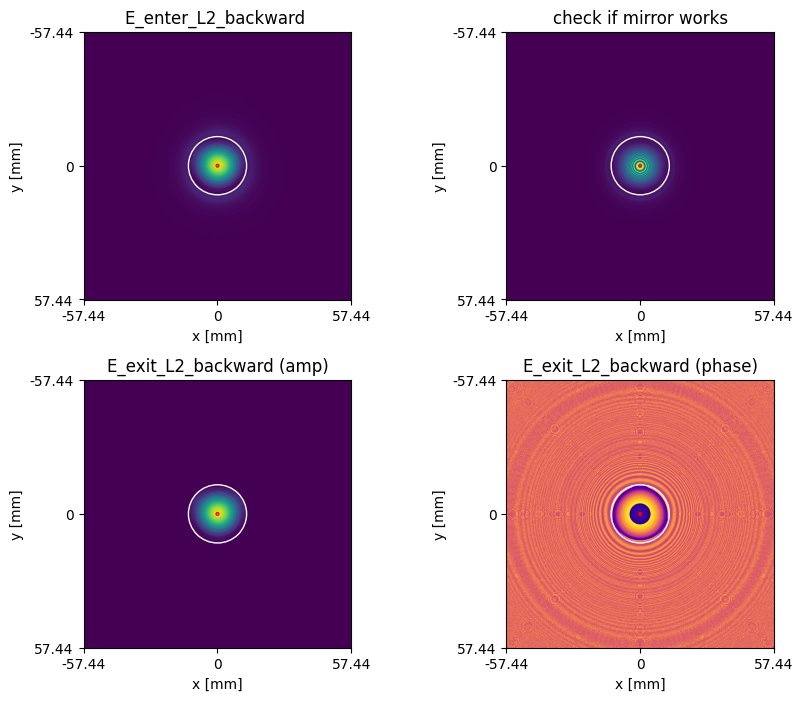

In [35]:
fig4 = QCLFigure(2,2,10,8, hspace = 0.3)
fig4.plot(np.abs(E_enter_L2_backward) , pixelSizeX, pos = (0,0), title = 'E_enter_L2_backward ', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig4.plot(np.abs(E_enter_L2_backward-E_exit_L2_forward), pixelSizeX, pos = (0,1), title = 'check if mirror works', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig4.plot(np.abs(E_exit_L2_backward), pixelSizeX, pos = (1,0), title = 'E_exit_L2_backward (amp)', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig4.plot(np.angle(E_exit_L2_backward), pixelSizeX, pos = (1,1), title = 'E_exit_L2_backward (phase)', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'plasma')

# Propagate from lens L2 back to QCL

In [36]:
# back-propagate from L2 to L1 (distance d2)
E_enter_L1_backward = propagate(E_exit_L2_backward, propagator, d2)

# apply lens clear aperture
E_enter_L1_backward_apertured = (E_enter_L1_backward*lens_aperture).astype(np.complex64)

# apply quadratic phase of the lens
E_exit_L1_backward = applyQuadraticPhase(E_enter_L1_backward_apertured, wavelength, f1, R_squared)

# back-propagate from L1 to QCL (distance d1)
E_QCL_coupled = propagate(E_exit_L1_backward, propagator, d1)

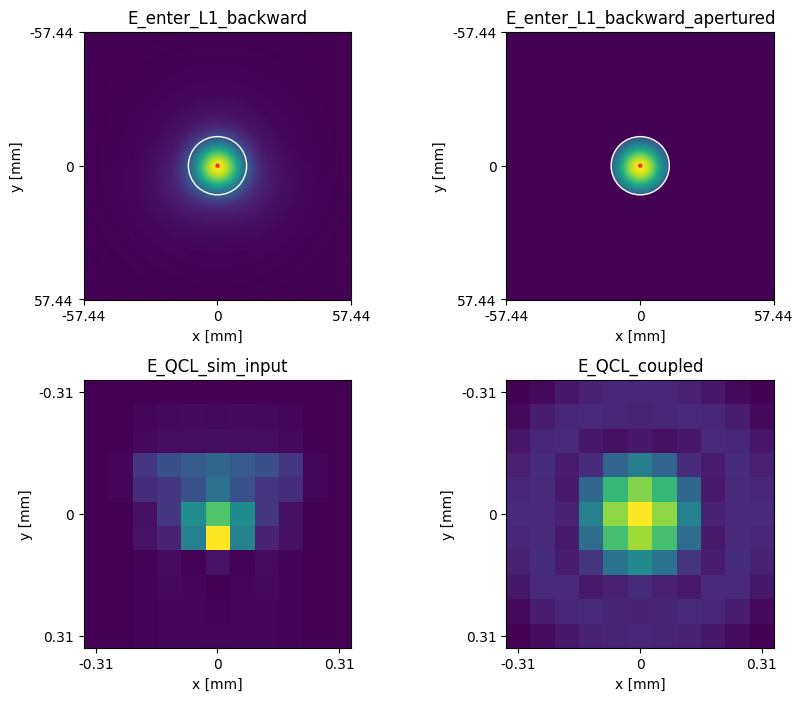

In [37]:
fig5 = QCLFigure(2,2,10,8, hspace = 0.3)
fig5.plot(np.abs(E_enter_L1_backward) , pixelSizeX, pos = (0,0), title = 'E_enter_L1_backward', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig5.plot(np.abs(E_enter_L1_backward_apertured) , pixelSizeX, pos = (0,1), title = 'E_enter_L1_backward_apertured', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, zoom = 2, colormap = 'viridis')
fig5.plot(np.abs(E_QCL_sim_input), pixelSizeX, pos = (1,0), title = 'E_QCL_sim_input', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, 
          zoom = 350, colormap = 'viridis')
fig5.plot(np.abs(E_QCL_coupled) , pixelSizeX, pos = (1,1), title = 'E_QCL_coupled', 
          plot_center_circle = True, circle_radius = 10,
          plot_lens_aperture = True, lens_aperture_radius = lens_clear_aperture_radius, 
          plot_integration_area = True, zoom = 350, colormap = 'viridis')